<a href="https://colab.research.google.com/github/chablis8/Projects/blob/master/times_series_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Times Series Analysis

#### Using time series models: ARIMA(Autoregressive Integrated Moving Averages) / Seasonal ARIMA to predict the future demand

- Visualize the Time Series Data
- Make the time series data stationary
- Plot the Correlation and AutoCorrelation Charts
- Construct the ARIMA Model or Seasonal ARIMA based on the data
Use the model to make predictions

__author__ = "Jeffrey Wong"

__email__ = "jeffrey-wong@live.com"

__acknowledgement__ = "Krish Naik" https://www.youtube.com/channel/UCNU_lfiiWBdtULKOw6X0Dig

## **Part 1 - DEFINE**
- To help the market analyst to learn the business cycle and predict future demend of the product


In [1]:
#@title Module Presettings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.style.use('bmh')

#Mount google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## **Part 2 Discovery**

In [2]:
df = pd.read_csv('/content/drive/MyDrive/time_series/perrin-freres-monthly-champagne-.csv')

In [3]:
df.head()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [4]:
#rename columns
df.columns = ['month', 'sales']

In [5]:
df.info()
# the dataset is 107 rows x 2 columns
#check to see if there are any missing, notice that there's one missing in month column and 2 missing in sales column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   month   106 non-null    object 
 1   sales   105 non-null    float64
dtypes: float64(1), object(1)
memory usage: 1.8+ KB


In [6]:
# display the missing rows
df[df.isnull().any(axis=1)]

,month,sales
105,NaN,NaN
106,Perrin Freres monthly champagne sales millions...,NaN


In [7]:
# remove the missing data rows
df.dropna(inplace=True)
df.tail()

,month,sales
100,1972-05,4618.0
101,1972-06,5312.0
102,1972-07,4298.0
103,1972-08,1413.0
104,1972-09,5877.0


In [8]:
# Convert Month into Datetime series and reindex with the month
df['month'] = pd.to_datetime(df['month'])
df.set_index('month',inplace=True)
df.head()

,sales
month,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0


- Visualize the data, this appears to be seasonal

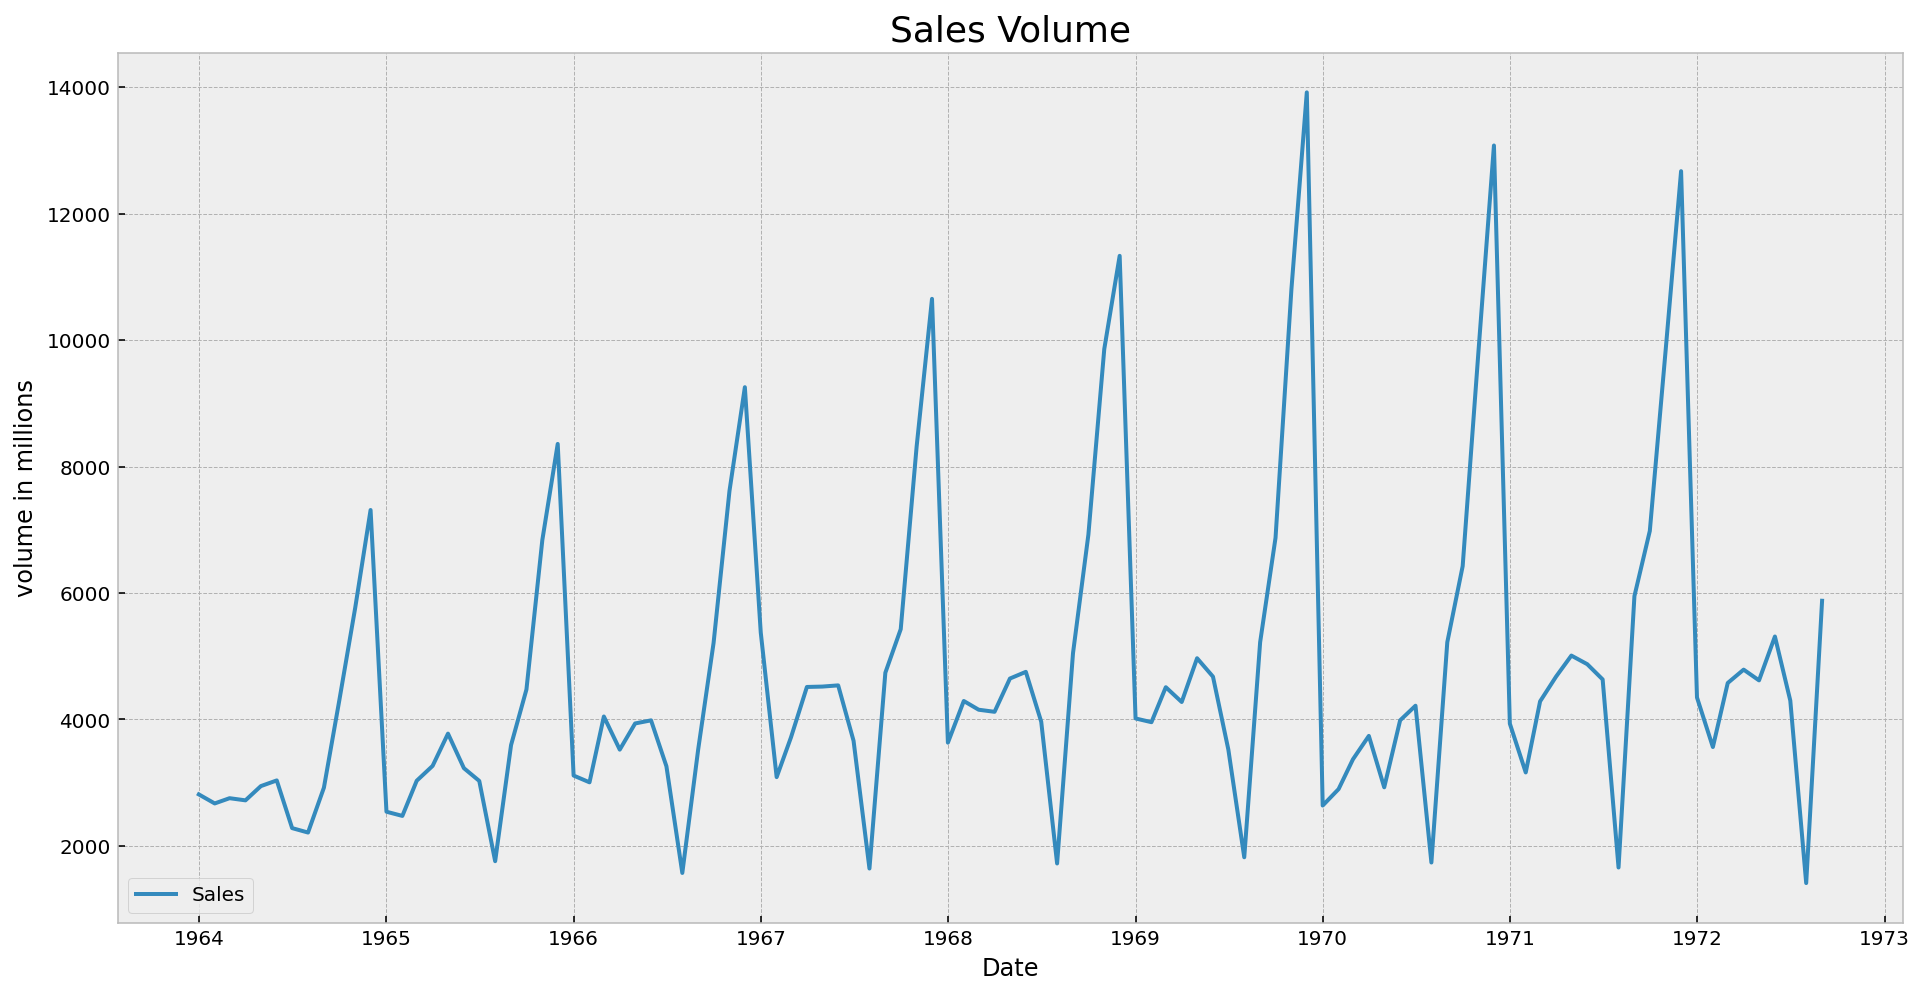

In [9]:
plt.figure(figsize=(16,8))
plt.title('Sales Volume', fontsize=18)
plt.xlabel('Date', fontsize=12)
plt.ylabel('volume in millions', fontsize=12)
plt.plot(df.sales)
plt.legend(['Sales'], loc='lower left')
plt.show()

## **Part 3 - Develop**

In [10]:
# In order to use ARIMA model, we need to test whether the data is stationary, meaning no change of the average.
from statsmodels.tsa.stattools import adfuller

#define a funtion to test the stationarity

#H0: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(H0), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [11]:
adfuller_test(df.sales)
# the data is not stationary so we need to calculate the difference in rows

ADF Test Statistic : -1.8335930563276228
p-value : 0.363915771660245
#Lags Used : 11
Number of Observations Used : 93
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


- Convert the time series to be stationary by creating a difference column

In [12]:
df['YoY'] = df.sales.diff(12) # year-over-year change
df['MoM'] = df.sales.diff()  # Month over Month change
df.head(20)

,sales,YoY,MoM
month,,,
1964-01-01,2815.0,NaN,NaN
1964-02-01,2672.0,NaN,-143.0
1964-03-01,2755.0,NaN,83.0
1964-04-01,2721.0,NaN,-34.0
1964-05-01,2946.0,NaN,225.0
1964-06-01,3036.0,NaN,90.0
1964-07-01,2282.0,NaN,-754.0
1964-08-01,2212.0,NaN,-70.0
1964-09-01,2922.0,NaN,710.0


In [13]:
## Again test dickey fuller test
adfuller_test(df['YoY'].dropna())

ADF Test Statistic : -7.626619157213164
p-value : 2.060579696813685e-11
#Lags Used : 0
Number of Observations Used : 92
strong evidence against the null hypothesis(H0), reject the null hypothesis. Data has no unit root and is stationary


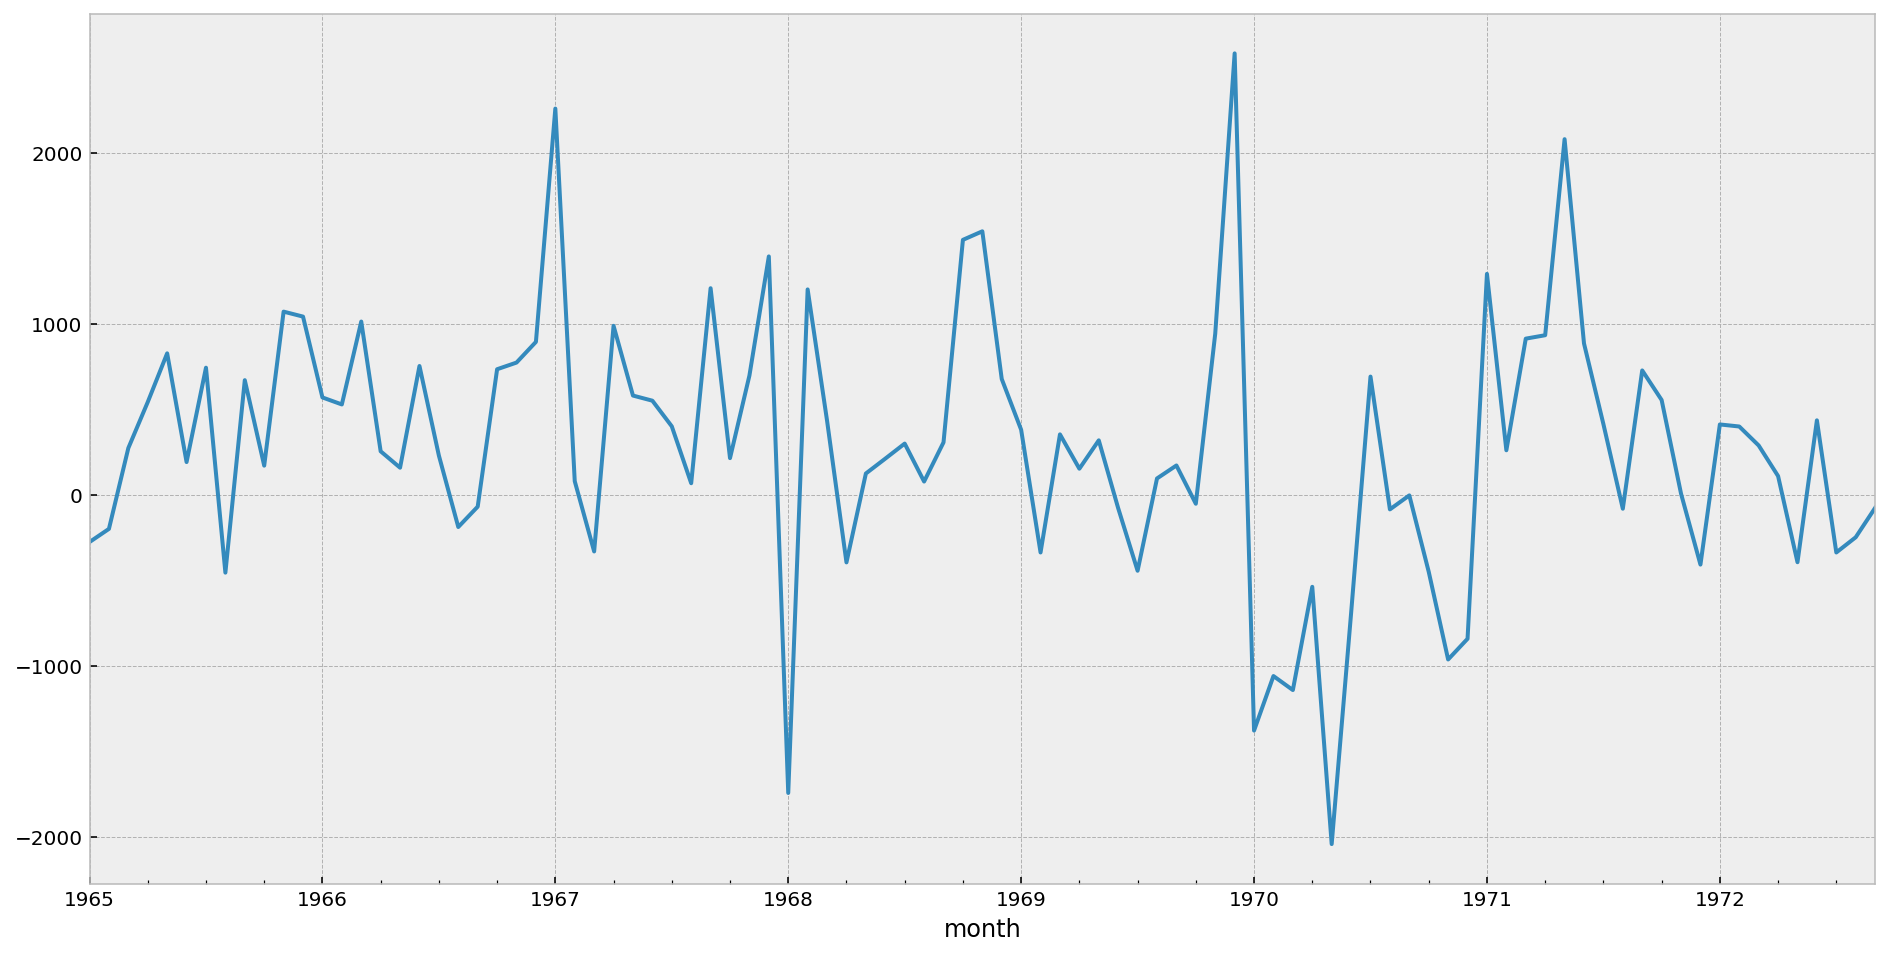

In [14]:
# the trend now looks a lot more stationary
plt.figure(figsize=(16,8))
df['YoY'].dropna().plot()
plt.show()

#### Autoregression Model: $y_t= c+ \theta_1 y_{t-1}+\theta_2 y_{t-2}...+\theta_p y_{t-p}+\epsilon_t$
- In the autogression model, we assume that the current values is correlated to historical values of previous cycles. In order for us to find out how many cycles away of data make most sense, we need to look at the PACF and ACP

- Identification of an AR model is often best done with the PACF.
For an AR model, the theoretical PACF “shuts off” past the order of the model. The phrase “shuts off” means that in theory the partial autocorrelations are equal to 0 beyond that point. Put another way, the number of non-zero partial autocorrelations gives the order of the AR model. By the “order of the model” we mean the most extreme lag of x that is used as a predictor.
Identification of an MA model is often best done with the ACF rather than the PACF.

- For an MA model, the theoretical PACF does not shut off, but instead tapers toward 0 in some manner. A clearer pattern for an MA model is in the ACF. The ACF will have non-zero autocorrelations only at lags involved in the model.

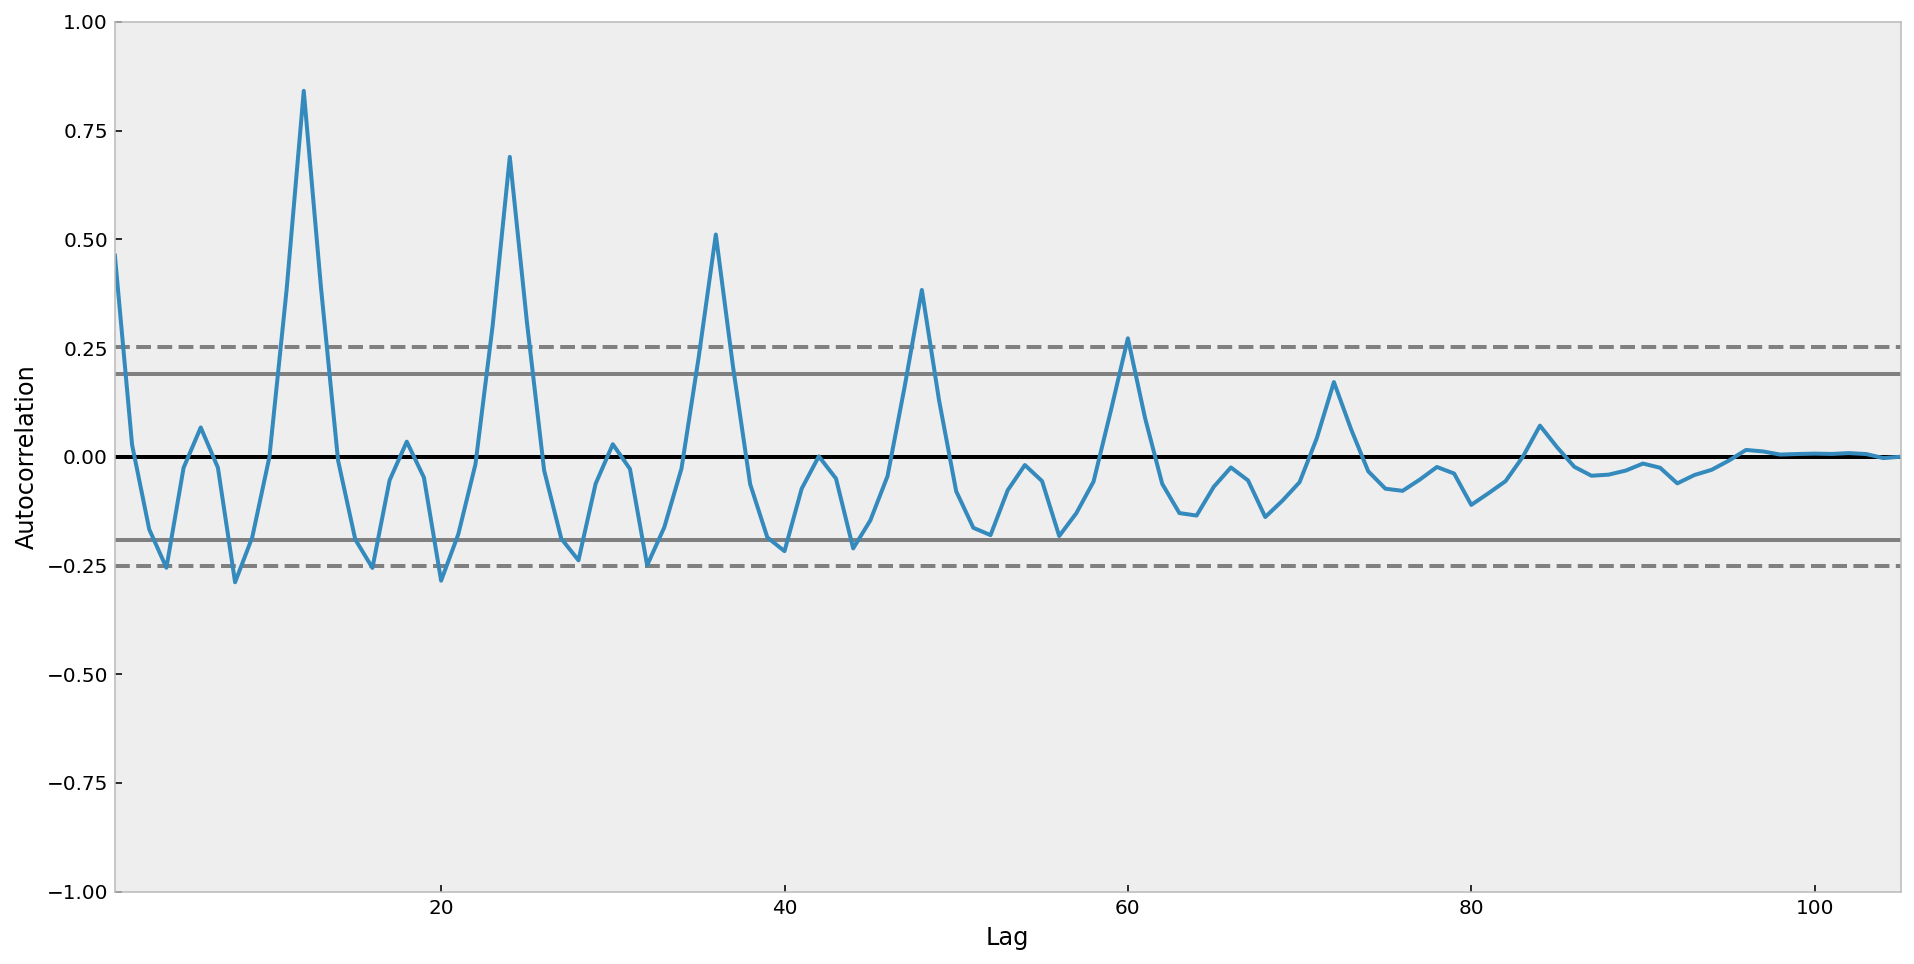

In [15]:
from pandas.plotting import autocorrelation_plot
plt.figure(figsize=(16,8))
autocorrelation_plot(df.sales)
plt.show()

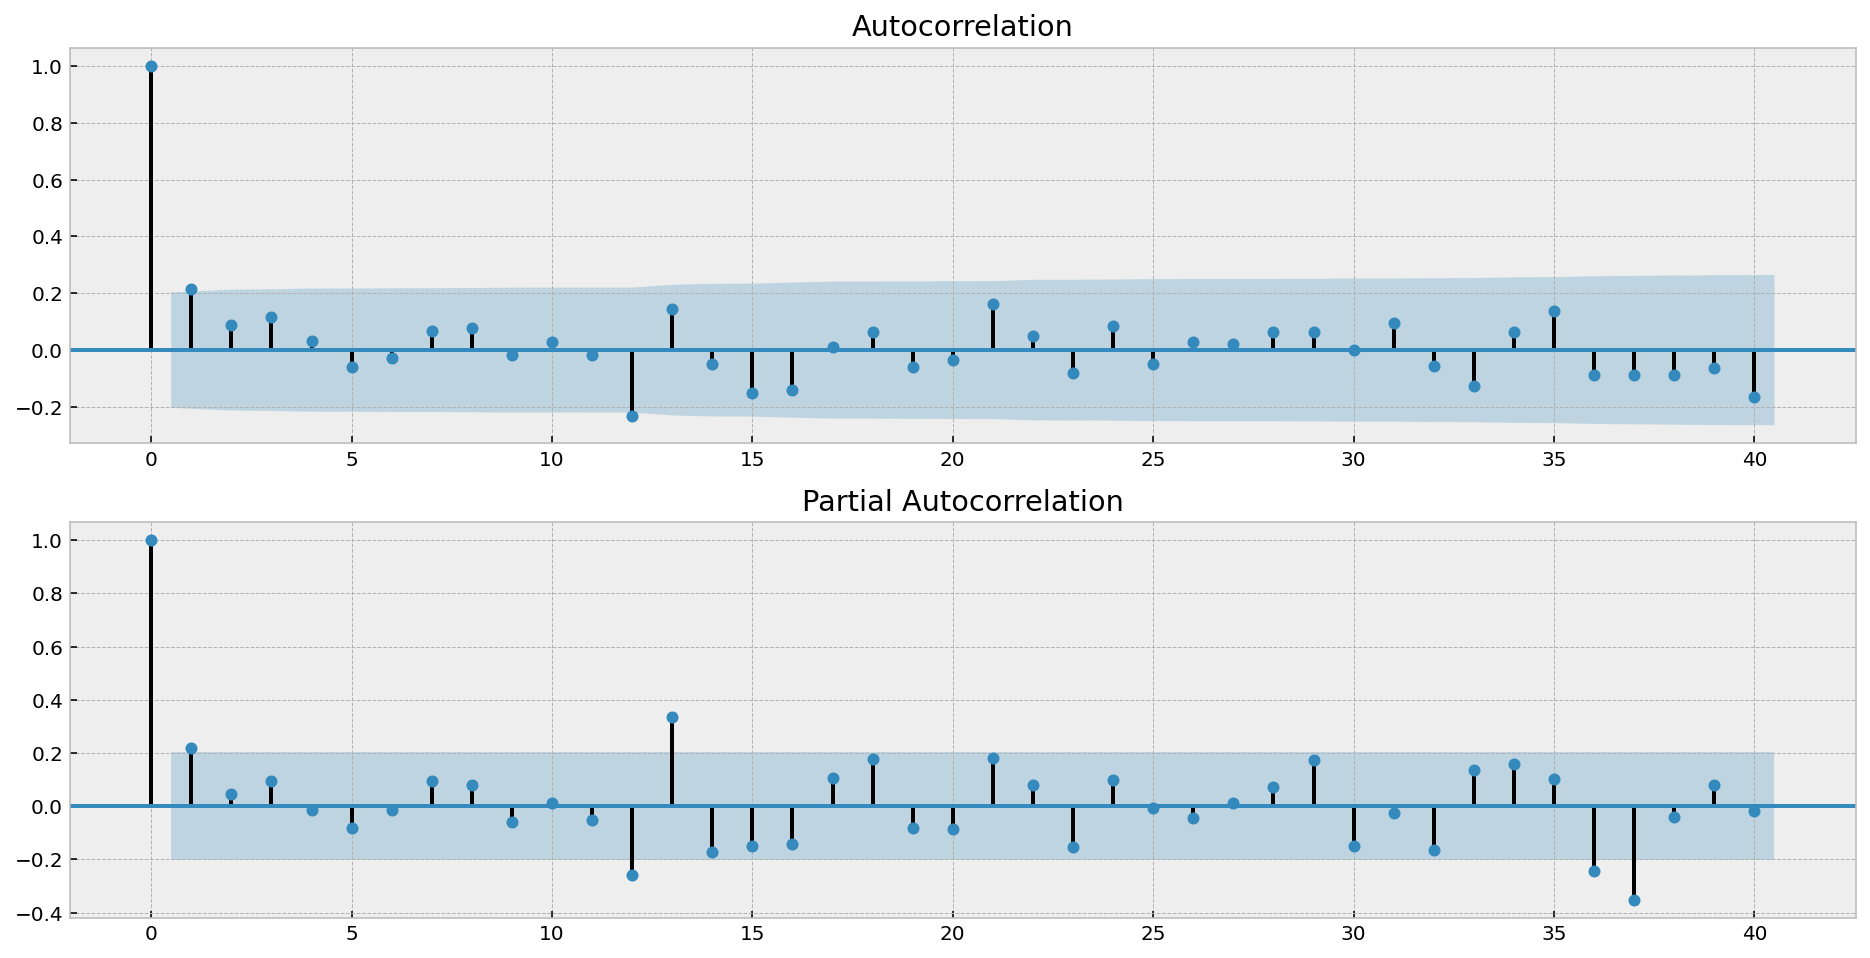

In [16]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df['YoY'].dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df['YoY'].dropna(),lags=40,ax=ax2)

# set p,d,q of the Seasonal ARIMA model as 1, 1, 1

In [17]:
import statsmodels.api as sm

model=sm.tsa.statespace.SARIMAX(df['sales'].iloc[:90],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit() #train with 90% of the data

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [18]:
df['forecast'] = results.predict(start=90, end=104, dynamic=True)

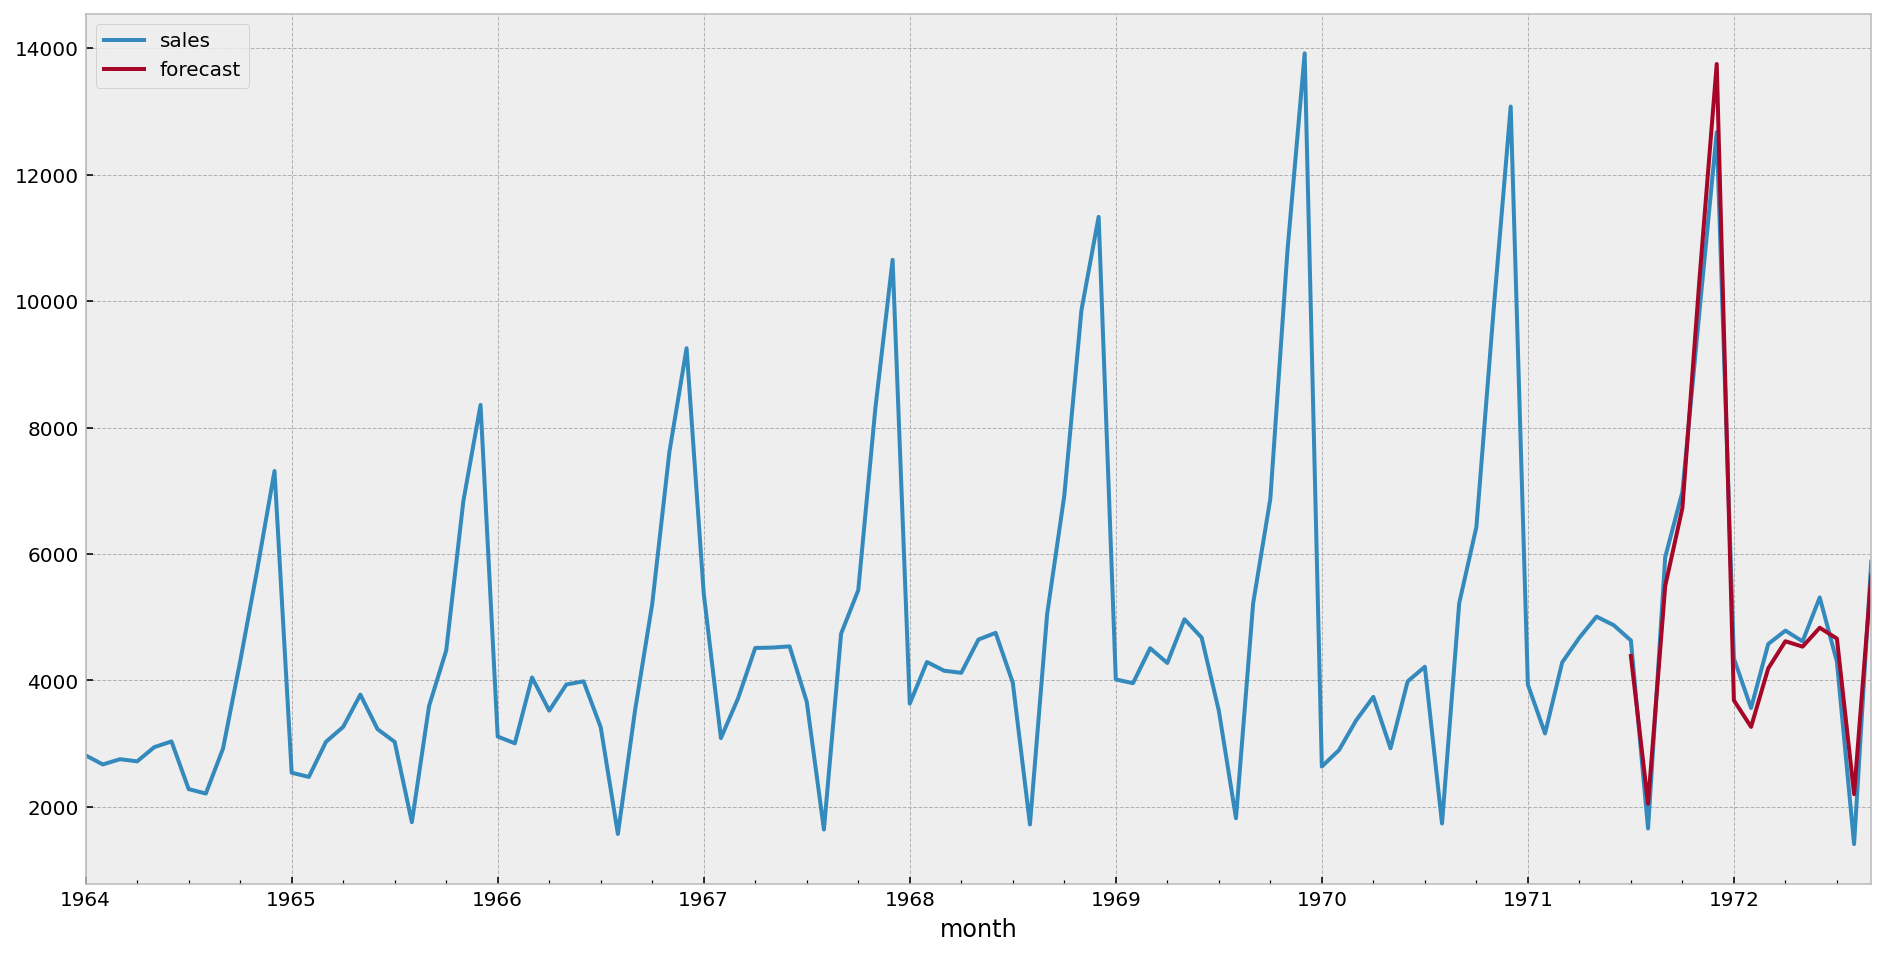

In [19]:
df[['sales', 'forecast']].plot(figsize=(16, 8))
plt.show()

In [20]:
df.dropna()[['sales', 'forecast']]

,sales,forecast
month,,
1971-07-01,4633.0,4387.097660
1971-08-01,1659.0,2050.484195
1971-09-01,5951.0,5495.402045
1971-10-01,6981.0,6725.880010
1971-11-01,9851.0,10363.171871
1971-12-01,12670.0,13748.036530
1972-01-01,4348.0,3685.617397
1972-02-01,3564.0,3266.229351
1972-03-01,4577.0,4190.833708


In [21]:
from sklearn.metrics import mean_squared_error
print("The MSE is {:.2f}".format(mean_squared_error(df.dropna().sales, df.dropna().forecast)))
print("The RMSE is {:.2f}".format(np.sqrt(mean_squared_error(df.dropna().sales, df.dropna().forecast))))

The MSE is 243619.48
The RMSE is 493.58


## **Part 4 - Deploy**

In [22]:
# create future time horizon for prediction data
from pandas.tseries.offsets import DateOffset

future_dates = [df.index[-1]+ DateOffset(months=x)for x in range(0,24)]  #forecast the next 24 months
future_datest_df = pd.DataFrame(index=future_dates[1:],columns=df.columns)

In [23]:
df = pd.concat([df, future_datest_df])

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 128 entries, 1964-01-01 to 1974-08-01
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sales     105 non-null    float64
 1   YoY       93 non-null     float64
 2   MoM       104 non-null    float64
 3   forecast  15 non-null     float64
dtypes: float64(4)
memory usage: 5.0 KB


In [25]:
# keep the rolling 105 months of actual sales volume for the future training
model=sm.tsa.statespace.SARIMAX(df['sales'].dropna().iloc[-105:],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


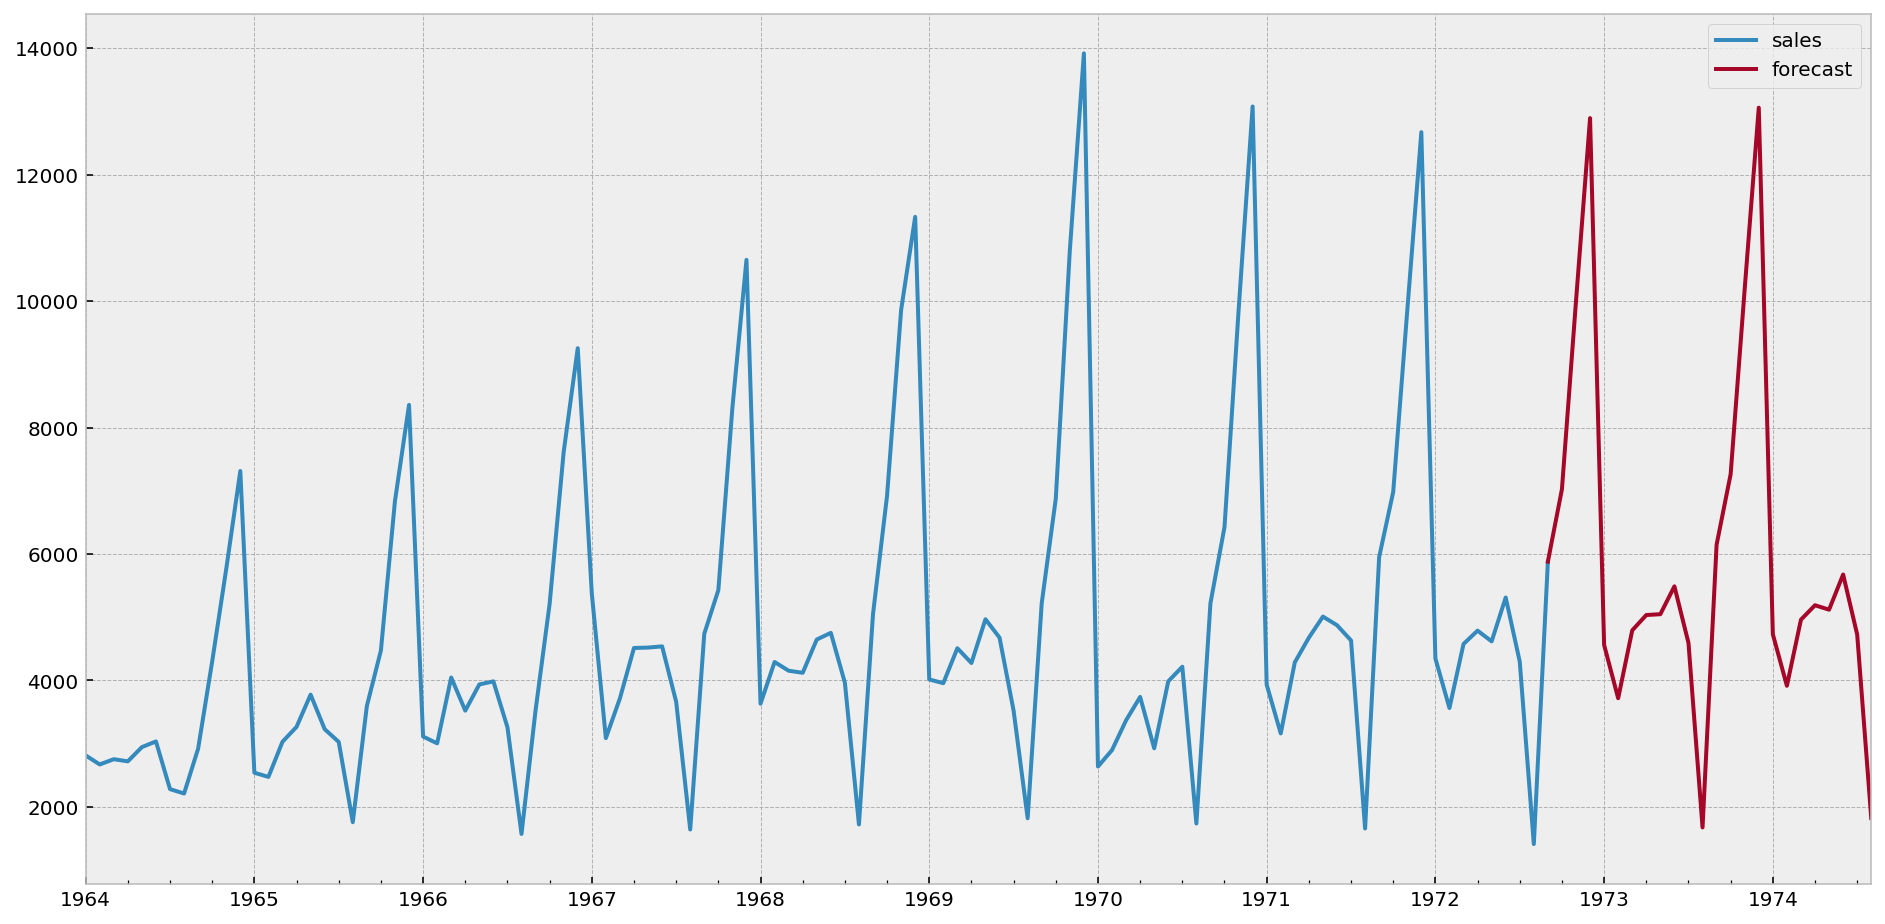

In [26]:
df['forecast'] = results.predict(start = 104, end = 127, dynamic= True)  
df[['sales', 'forecast']].plot(figsize=(16, 8))